# Naive Bayes classifier  in spam classification
( Kashtanova, Goldin )

Lorsque les ressources computationnelles ne permettent pas de résoudre un SVM ou une régression
logistique, il est utile d’avoir des modèles plus simple à apprendre. C’est le cas du modèle naïf de Bayes qui est quelquefois très efficace. (Contrairement à ce que dit la page wikipédia en français, il ne s’agit pas d’une méthode bayésienne).

— http://en.wikipedia.org/wiki/Naive_Bayes_classifier

— Naive Bayes : A. McCallum and K. Nigam. A comparison of event models for Naive Bayes text classification. In AAAI-98 Workshop on Learning for Text Categorization, 1998.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.65.9324&rep=rep1&type=pdf

— Book Chapter : Naive Bayes text classification, Introduction to Information Retrieval
http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html

## Base N1 (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/)
``Data base : SMS`` Almeida, T.A., Gamez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.


In [1]:
import re
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from collections import Counter

In [2]:
def PreprocessSentence (s):
    # Simple preprocessing: 
    # to lower case -> replace all digit strings with '' -> split with punctuation and blank characters
    words = re.split(r'\W+', re.sub(r'\d+', '', str.lower(s)))
    del words[-1]
    return words

def LoadData (fileName = "data_spam/SMSSpamCollection.txt"):
    # Read data from text file and makes make some preprocessing with input sentence 
    df = pd.DataFrame()
    with open (fileName ,"r") as f :
        f . readline()
        for line in f:
            data = line.split('\t') # num=2)
            df = df.append([[data[0],PreprocessSentence(data[1])]], ignore_index = True) 
    
    df.columns=['lab', 'data']
    return df

def CreateDataSet (dataSet, proportions = np.array([0.6, 0.2, 0.2])):
    # Creates a list with indices of train, validation and test sets  
    proportions_new = proportions/np.sum(proportions)
    
    hamIdx = dataSet[dataSet.lab =='ham'].index 
    nham = len(hamIdx)  
    spamIdx = dataSet[dataSet.lab =='spam'].index 
    nspam = len(spamIdx)
    hamTrainIdx = np.random.choice(hamIdx, math.floor(proportions_new[0]*nham), replace=False)
    hamIdx = np.setdiff1d(hamIdx, hamTrainIdx, assume_unique=False)
    spamTrainIdx = np.random.choice(spamIdx, math.floor(proportions_new[0]*nspam), replace=False)
    spamIdx = np.setdiff1d(spamIdx, spamTrainIdx)
    hamValidationIdx = np.random.choice(hamIdx, math.floor(proportions_new[1]*nham), replace=False)
    hamIdx = np.setdiff1d(hamIdx, hamValidationIdx)
    spamValidationIdx = np.random.choice(spamIdx, math.floor(proportions_new[1]*nspam), replace=False)
    spamIdx = np.setdiff1d(spamIdx, spamValidationIdx)  
    
    # train, validation and test sets
    train = np.random.permutation(np.union1d(hamTrainIdx, spamTrainIdx))
    validation = np.random.permutation(np.union1d(hamValidationIdx, spamValidationIdx))
    test = np.random.permutation(np.union1d(hamIdx, spamIdx))

    ds =  dict()
    ds['train'] = train
    ds['validation'] = validation
    ds['test'] = test
    
    return ds #train, validation, test


### Our realisation of Naive Bayes classifier

In [3]:
def CreateModel(data, laplaceFactor = 0):
    # creates naive bayes spam classifier based on data
    #  INPUT:    train data frame with lab and data fields;laplace factor
    #  OUTPUT:   trained naive bayes model
    
    m = dict(laplaceFactor = laplaceFactor)
    m['total'] = len(data.lab)
    
    m['ham'] = dict()
    m['spam'] = dict()
    
    m['hamLabelCount'] = len(data[data.lab =='ham'])
    m['spamLabelCount'] = len(data[data.lab =='spam'])
    m['hamWordCount'] = 0
    m['spamWordCount'] = 0
    
    uniqueWordSet = set()
    
    for i in range(len(data.lab)):
        sentence = data.data[i]
        uniqueWordSet.update(sentence)
        
        for j in range(len(sentence)):            
            if(data.lab[i] == 'ham'):
                if m['ham'].get(sentence[j]) is None:
                    m['ham'][sentence[j]] = 1
                else : 
                    m['ham'][sentence[j]] = m['ham'][sentence[j]] + 1
            
                m['hamWordCount'] = m['hamWordCount'] + 1
            
            else:
                if(data.lab[i] == 'spam'):
                    if m['spam'].get(sentence[j]) is None:
                        m['spam'][sentence[j]] = 1
                    else : 
                        m['spam'][sentence[j]] = m['spam'][sentence[j]] + 1

                m['spamWordCount'] = m['spamWordCount'] + 1
    
    m['uniqueWordCount'] = len(uniqueWordSet)
    
    return(m) 

In [4]:
def GetCount(w, ls) :
    if ls.get(w) is None:
        return 0
    return ls.get(w)
    
def ClassifySentense(s, model, preprocess = True):
    # calculate class of the input sentence based on the model
    #  INPUT:    string sentence, model from CreateModel and
    #            bool flag, if sentence should be preprocessed 
    #  OUTPUT:   class of message HAM or SPAM
    
    words = s
    if(preprocess):
        words = PreprocessSentence(s)

    ham = math.log(model['hamLabelCount']/(model['hamLabelCount'] + model['spamLabelCount']))
    spam = math.log(model['spamLabelCount']/(model['hamLabelCount'] + model['spamLabelCount']))
    for i in range(len(words)):
        ham = ham + math.log((GetCount(words[i], model['ham']) + model['laplaceFactor']) /
                             (model['hamWordCount'] + model['laplaceFactor']*model['uniqueWordCount']))
        spam = spam + math.log((GetCount(words[i], model['spam']) + model['laplaceFactor']) /
                               (model['spamWordCount'] + model['laplaceFactor']*model['uniqueWordCount']))
    if(ham >= spam):
         return ('ham')
    
    return ('spam')

def TestModel (data, model):
    # calculate percentage of errors
    #  INPUT:    data for testing and model
    #  OUTPUT:   percentage of mistakes
    errors = 0
    for i in range(len(data.lab)):
        predictedLabel = ClassifySentense(data.data[i], model, preprocess = False)
        if (predictedLabel != data.lab[i]):
            errors = errors + 1
    return (errors/len(data.lab))

def CrossValidation(trainData, validationData, laplaceFactorValues, showLog = False):
    # Crossvalidation, search best Laplace factrom from given vector
    #  INPUT:    train data, validation data, vector of possible 
    #            factor values, and flag, if log should be shown
    #  OUTPUT:   vector of percentage of errors for corresponding Laplace
    #            factor values
    cvErrors = np.full(len(laplaceFactorValues), None)
    
    for i in range(len(laplaceFactorValues)):
        model = CreateModel(trainData, laplaceFactor = laplaceFactorValues[i])
        cvErrors[i] = TestModel(validationData, model)
        if(showLog):
            print("For laplaceFactorValues = ", laplaceFactorValues[i], 
                  " : error is ", cvErrors[i], "\n")
    return cvErrors

In [5]:
df = LoadData()

In [6]:
ds = CreateDataSet(df, proportions = np.array([0.6, 0.2, 0.2]))
laplaceFactorValues = np.arange(1,11)

DF_train = df.loc[ds['train']].reset_index().drop(['index'], axis='columns')
DF_test = df.loc[ds['test']].reset_index().drop(['index'], axis='columns')
DF_valid = df.loc[ds['validation']].reset_index().drop(['index'], axis='columns')

In [7]:
cvErrors = CrossValidation(DF_train, DF_valid, laplaceFactorValues, showLog = True)

For laplaceFactorValues =  1  : error is  0.019748653500897665 

For laplaceFactorValues =  2  : error is  0.01615798922800718 

For laplaceFactorValues =  3  : error is  0.017953321364452424 

For laplaceFactorValues =  4  : error is  0.018850987432675045 

For laplaceFactorValues =  5  : error is  0.02244165170556553 

For laplaceFactorValues =  6  : error is  0.02333931777378815 

For laplaceFactorValues =  7  : error is  0.02872531418312388 

For laplaceFactorValues =  8  : error is  0.03052064631956912 

For laplaceFactorValues =  9  : error is  0.03231597845601436 

For laplaceFactorValues =  10  : error is  0.03411131059245961 



In [41]:
bestLaplaceFactor = laplaceFactorValues[np.argmin(cvErrors)] #2
#print(bestLaplaceFactor)
model = CreateModel(data=DF_train, laplaceFactor=bestLaplaceFactor)
testResult = TestModel(DF_test, model)

result_our = []
for i in range(len(DF_test['data'])):
    result_our.append(ClassifySentense(DF_test['data'][i], model, preprocess = False))
    
result_our = np.array(result_our)

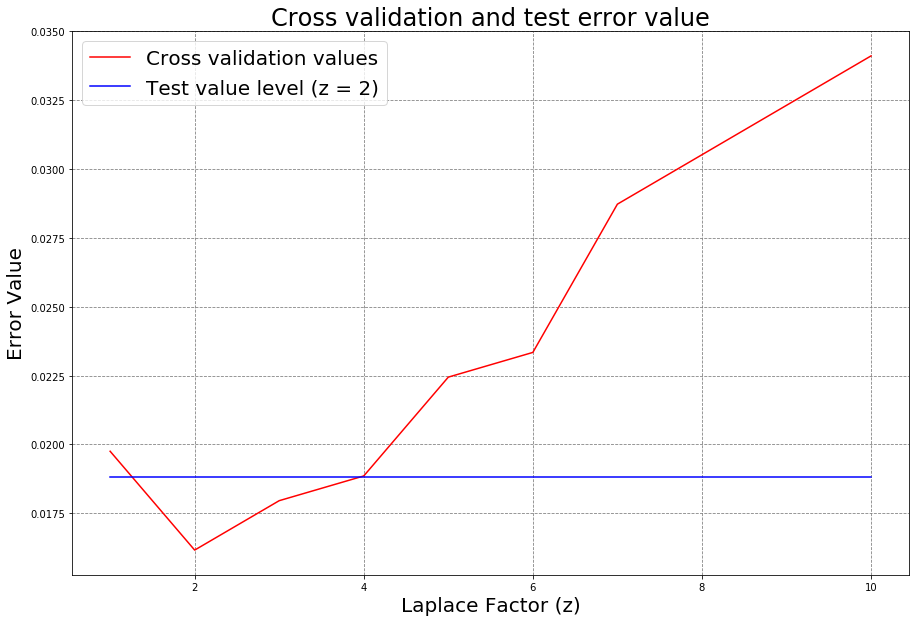

In [9]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(111)
ax1.plot(np.arange(1, len(cvErrors)+1), cvErrors, c='red', label='Cross validation values')
ax1.plot(np.arange(1, len(cvErrors)+1), np.full(len(cvErrors), testResult), 
         c='blue', label='Test value level (z = {})'.format(bestLaplaceFactor))
ax1.set_title('Cross validation and test error value', fontsize = 24)
ax1.legend(fontsize = 20)
ax1.grid(color='gray', linestyle='dashed')
plt.xlabel('Laplace Factor (z)', fontsize = 20)
plt.ylabel('Error Value', fontsize = 20) 
plt.savefig('cros_val.png')
plt.show()

### Some classifiers from Sklearn

In [10]:
from collections import Counter
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# some preprocessing for Sklearn's classifiers
# creating word dictionary
def make_Dictionary(data):
    all_words = []   
    for i in range(len(data)):
        words = data[i]
        all_words += words
        
    dictionary = Counter(all_words)
    
    #dictionary = dictionary.most_common(3000)
    return dictionary
 
#feature extraction process
def extract_features(data, dictionary): 
    features_matrix = np.zeros((len(data),len(dictionary)))
    for i in range(len(data)):
        words = data[i]
        for word in words:
                wordID = 0
                for j,d in enumerate(dictionary):
                    if d == word:
                        wordID = j
                        features_matrix[i,wordID] = words.count(word)
    
    return features_matrix

In [12]:
dictionary = make_Dictionary(np.array(DF_train['data']))
train_matrix = extract_features(np.array(DF_train['data']), dictionary)
train_labels = np.array(DF_train['lab'])

In [13]:
# Training LDA, SVM and Naive bayes classifier
model1 = MultinomialNB()
model2 = LinearSVC()
model3 = LinearDiscriminantAnalysis()
model4 = QuadraticDiscriminantAnalysis()
model5 = KNeighborsClassifier()

model1.fit(train_matrix,train_labels)
model2.fit(train_matrix,train_labels)
model3.fit(train_matrix,train_labels)
model4.fit(train_matrix,train_labels)
model5.fit(train_matrix,train_labels)

C:\Users\13_Vi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\13_Vi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [14]:
# Test the unseen mails for Spam
test_matrix = extract_features(np.array(DF_test['data']), dictionary)
test_labels = np.array(DF_test['lab'])

result1 = model1.predict(test_matrix)
result2 = model2.predict(test_matrix)
result3 = model3.predict(test_matrix)
result4 = model4.predict(test_matrix)
result5 = model5.predict(test_matrix)

In [15]:
print ('Confusion matrix :\n')

print('\nFor our NB : \n', confusion_matrix(test_labels,result_our))
print ('\nFor MultinomialNB : \n', confusion_matrix(test_labels,result1))
print ('\nFor LinearSVC : \n', confusion_matrix(test_labels,result2))
print ('\nFor LDA : \n', confusion_matrix(test_labels,result3))
print ('\nFor QDA : \n', confusion_matrix(test_labels,result4))
print ('\nFor KNN : \n', confusion_matrix(test_labels,result5))

Confusion matrix :


For our NB : 
 [[956  10]
 [ 11 139]]

For MultinomialNB : 
 [[960   6]
 [ 10 140]]

For LinearSVC : 
 [[961   5]
 [ 12 138]]

For LDA : 
 [[776 190]
 [ 43 107]]

For QDA : 
 [[959   7]
 [ 54  96]]

For KNN : 
 [[965   1]
 [ 78  72]]


###### Exemples :
First message is a HAM, second is a SPAM :

In [16]:
phrase_1 = 'As per your request "Melle Melle (Oru Minnaminunginte Nurungu Vettam)" has been set as your callertune for all Callers. Press *9 to copy your friends Callertune'
phrase_2 = 'URGENT! We are trying to contact U.Todays draw shows that you have won a 2000 prize GUARANTEED. Call 090 5809 4507 from land line. Claim 3030. Valid 12hrs only'

``Our method`` :

In [17]:
print(ClassifySentense(phrase_1, model))
print(ClassifySentense(phrase_2, model))

spam
spam


``Others`` :

In [18]:
exempl_matrix_1 = extract_features([phrase_1], dictionary)

In [19]:
print(model1.predict(exempl_matrix_1))
print(model2.predict(exempl_matrix_1))
print(model3.predict(exempl_matrix_1))
print(model4.predict(exempl_matrix_1))
print(model5.predict(exempl_matrix_1))

['ham']
['spam']
['spam']
['ham']
['ham']


In [20]:
exempl_matrix_2 = extract_features([phrase_2], dictionary)

In [21]:
print(model1.predict(exempl_matrix_2))
print(model2.predict(exempl_matrix_2))
print(model3.predict(exempl_matrix_2))
print(model4.predict(exempl_matrix_2))
print(model5.predict(exempl_matrix_2))

['ham']
['ham']
['spam']
['ham']
['ham']


#### Difficult messages for our algoritm :

In [22]:
def print_FN_sentence (y_pred, y_true, data_base):
    print('False-Negative sentences :')
    k = 1
    for i in range (len(y_pred)):
        if (y_true[i] == 'ham') and (y_pred[i] == 'spam'):
            print ('\n', k, ': \t' ,' '.join(str(e) for e in data_base['data'][i]), '\n')
            k+=1
            
def print_FP_sentence (y_pred, y_true, data_base):
    print('False-Positive sentences :')
    k = 1
    for i in range (len(y_pred)):
        if (y_true[i] == 'spam') and (y_pred[i] == 'ham'):
            print ('\n', k, ': \t' ,' '.join(str(e) for e in data_base['data'][i]), '\n')
            k+=1

In [23]:
print_FN_sentence (result_our, test_labels, DF_test)

False-Negative sentences :

 1 : 	 ambrith madurai met u in arun dha marrge remembr 


 2 : 	 waiting for your call 


 3 : 	 we have sent jd for customer service cum accounts executive to ur mail id for details contact us 


 4 : 	  cheers u tex mecause u werebored yeah okden hunny r uin wk sat soundâ s likeyour havin grfun j keep updat countinlots of loveme xxxxx 


 5 : 	 s antha num corrct dane 


 6 : 	 im in inperialmusic listeningthe weirdest track ever byâ leafcutter johnâ sounds like insects being molested someone plumbing remixed by evil men on acid 


 7 : 	 gettin rdy to ship comp 


 8 : 	 have you laid your airtel line to rest 


 9 : 	 life alle mone eppolum oru pole allalo 


 10 : 	 except theres a chick with huge boobs 



In [24]:
print_FP_sentence (result_our, test_labels, DF_test)

False-Positive sentences :

 1 : 	 did you hear about the new divorce barbie it comes with all of ken s stuff 


 2 : 	 do you ever notice that when you re driving anyone going slower than you is an idiot and everyone driving faster than you is a maniac 


 3 : 	 sms ac sun posts hello you seem cool wanted to say hi hi stop send stop to 


 4 : 	 a networks allow companies to bill for sms so they are responsible for their suppliers just as a shop has to give a guarantee on what they sell b g 


 5 : 	 more people are dogging in your area now call and join like minded guys why not arrange yourself there s this evening aâ minapn lsbb 


 6 : 	 hello we need some posh birds and chaps to user trial prods for champneys can i put you down i need your address and dob asap ta r 


 7 : 	 sms ac jsco energy is high but u may not know where channel it day ur leadership skills r strong psychic reply ans w question end reply end jsco 


 8 : 	 dont forget you can place as many free requests with s

## Base N2 (https://www.dropbox.com/s/yjiplngoa430rid/)

``Data base : emails`` Ion Androutsopoulos, John Koutsias, Konstantinos V. Chandrinos, George Paliouras
and Constantine D. Spyropoulos 'An Evaluation of Naive Bayesian Anti-Spam Filtering' 2000

In [25]:
train_dir = 'train-mails'
test_dir = 'test-mails'

In [26]:
def LoadData_emails (fileName, tag = 'train'):
    # Read data from text file and makes simple preprocessing: 
    #   to lower case -> replace all digit strings with 1 -> split with punctuation and blank characters
    df = pd.DataFrame()
    
    if tag == 'train':
        K = 351
    else : 
        if tag == 'test':
            K = 130
        else : 
            print('ERROR')
            return 0
    
    
    emails = [os.path.join(fileName,f) for f in os.listdir(fileName)]  
    k = 0
    for mail in emails:    
        with open(mail,"r") as m:
            if (k<K):
                df = df.append([['ham',PreprocessSentence(m.read())]], ignore_index = True) 
            else :
                df = df.append([['spam',PreprocessSentence(m.read())]], ignore_index = True) 
        k+=1
    
    df.columns=['lab', 'data']
    return df

In [27]:
df_emails = LoadData_emails(train_dir)
df_emails_test = LoadData_emails(test_dir, 'test')

In [28]:
ds_emails = CreateDataSet(df_emails, proportions = np.array([0.7, 0.3, 0.0]))
laplaceFactorValues_emails = np.arange(1,11)

In [29]:
DF_train_emails = df_emails .loc[ds_emails['train']].reset_index().drop(['index'], axis='columns')
DF_valid_emails = df_emails .loc[ds_emails['validation']].reset_index().drop(['index'], axis='columns')

DF_test_emails = df_emails_test.sample(frac=1).reset_index(drop=True)

cvErrors_emails = CrossValidation(DF_train_emails, DF_valid_emails, laplaceFactorValues_emails, showLog = True)

For laplaceFactorValues =  1  : error is  0.01904761904761905 

For laplaceFactorValues =  2  : error is  0.01904761904761905 

For laplaceFactorValues =  3  : error is  0.01904761904761905 

For laplaceFactorValues =  4  : error is  0.01904761904761905 

For laplaceFactorValues =  5  : error is  0.02857142857142857 

For laplaceFactorValues =  6  : error is  0.02857142857142857 

For laplaceFactorValues =  7  : error is  0.0380952380952381 

For laplaceFactorValues =  8  : error is  0.04285714285714286 

For laplaceFactorValues =  9  : error is  0.04285714285714286 

For laplaceFactorValues =  10  : error is  0.047619047619047616 



In [42]:
bestLaplaceFactor_emails = laplaceFactorValues_emails[np.argmin(cvErrors_emails)] #2
#print(bestLaplaceFactor_emails)
model_emails = CreateModel(data=DF_train_emails, laplaceFactor=bestLaplaceFactor_emails)
testResult_emails = TestModel(DF_test_emails, model_emails)

result_our_emails = []
for i in range(len(DF_test_emails['data'])):
    result_our_emails.append(ClassifySentense(DF_test_emails['data'][i], model_emails, preprocess = False))
    
result_our_emails = np.array(result_our_emails)

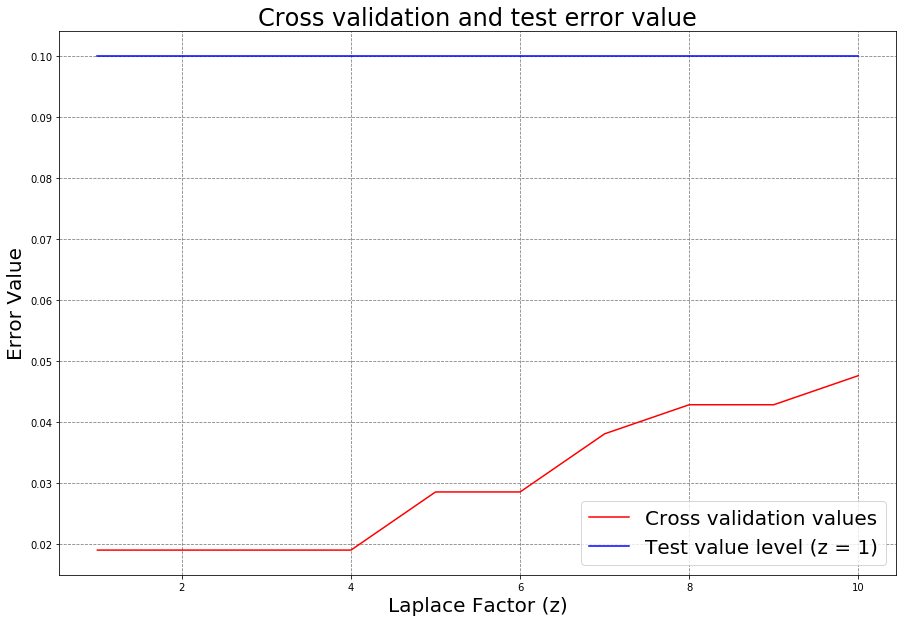

In [31]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(111)
ax1.plot(np.arange(1, len(cvErrors_emails)+1), cvErrors_emails, c='red', label='Cross validation values')
ax1.plot(np.arange(1, len(cvErrors_emails)+1), np.full(len(cvErrors_emails), testResult_emails), 
         c='blue', label='Test value level (z = {})'.format(bestLaplaceFactor_emails))
ax1.set_title('Cross validation and test error value', fontsize = 24)
ax1.legend(fontsize = 20)
ax1.grid(color='gray', linestyle='dashed')
plt.xlabel('Laplace Factor (z)', fontsize = 20)
plt.ylabel('Error Value', fontsize = 20) 
plt.savefig('cros_val_emails.png')
plt.show()

In [32]:
dictionary_emails  = make_Dictionary(np.array(DF_train_emails['data']))
train_matrix_emails  = extract_features(np.array(DF_train_emails['data']), dictionary_emails)
train_labels_emails  = np.array(DF_train_emails['lab'])

In [33]:
# Training LDA, SVM and Naive bayes classifier
model1_emails  = MultinomialNB()
model2_emails  = LinearSVC()
model3_emails  = LinearDiscriminantAnalysis()
model4_emails  = QuadraticDiscriminantAnalysis()
model5_emails  = KNeighborsClassifier()

model1_emails .fit(train_matrix_emails ,train_labels_emails )
model2_emails .fit(train_matrix_emails ,train_labels_emails )
model3_emails .fit(train_matrix_emails ,train_labels_emails )
model4_emails .fit(train_matrix_emails ,train_labels_emails )
model5_emails .fit(train_matrix_emails ,train_labels_emails )

C:\Users\13_Vi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\13_Vi\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
test_matrix_emails = extract_features(np.array(DF_test_emails['data']), dictionary_emails)
test_labels_emails = np.array(DF_test_emails['lab'])

In [35]:
result1_emails = model1_emails.predict(test_matrix_emails)
result2_emails = model2_emails.predict(test_matrix_emails)
result3_emails = model3_emails.predict(test_matrix_emails)
result4_emails = model4_emails.predict(test_matrix_emails)
result5_emails = model5_emails.predict(test_matrix_emails)

In [36]:
print ('Confusion matrix :\n')

print('\nFor our NB : \n', confusion_matrix(test_labels_emails,result_our_emails))
print ('\nFor MultinomialNB : \n', confusion_matrix(test_labels_emails,result1_emails))
print ('\nFor LinearSVC : \n', confusion_matrix(test_labels_emails,result2_emails))
print ('\nFor LDA : \n', confusion_matrix(test_labels_emails,result3_emails))
print ('\nFor QDA : \n', confusion_matrix(test_labels_emails,result4_emails))
print ('\nFor KNN : \n', confusion_matrix(test_labels_emails,result5_emails))


Confusion matrix :


For our NB : 
 [[115  15]
 [ 11 119]]

For MultinomialNB : 
 [[115  15]
 [  9 121]]

For LinearSVC : 
 [[113  17]
 [  3 127]]

For LDA : 
 [[115  15]
 [ 66  64]]

For QDA : 
 [[112  18]
 [ 77  53]]

For KNN : 
 [[ 74  56]
 [  2 128]]


In [37]:
print_FN_sentence (result_our_emails, test_labels_emails, DF_test_emails)

False-Negative sentences :

 1 : 	 subject conference research advance technology digital library second european conference research advance technology digital library european european ics forth university union research crete consortium informatic mathematic september heraklion crete greece web page http www csus forth gr eurodl e mail ecdl cc uch gr _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ objective conference second series european conference research technology digital library fund european commission s tmr programme objective bring together researcher multiple discipline whose science relate development digital library provide opportunity scientist form research community europe specific digital library development enable discuss issue strategy specific european context assist young researcher establish relationship senior scientist area interest enable review d

In [38]:
print_FP_sentence (result_our_emails, test_labels_emails, DF_test_emails)

False-Positive sentences :

 1 : 	 subject webmine free white paper datum mine web datum http www webminer com paper htm 


 2 : 	 subject data coffee northcoastcoffee com deat thu jan pst subject free coffee grinder reply remove northcoastcoffee com remove yourself our mail list message subject necessary dear fellow coffee drinker ve ever taste coffee bean roast few day before m talk believe one life s simple pleasure cup coffee truly great coffee coffee bean grind moment before brew s why north coast coffee free caf mill coffee grinder try our exceptional coffee here north coast coffee roast coffee order before order place collect combine order each morn specific coffee need day roast caf mill coffee grinder warranty normally retail absolutely free join mike s coffee crew purchase pound freshest coffee ever taste free caf mill coffee grinder http www northcoastcoffee com ccrew htm mike s coffee crew page s easy order within few day ll fun grind own coffee bean enjoy best coffee ever 

### Overfitting ?

In [39]:
result_our_emails = []
for i in range(len(DF_train_emails['data'])):
    result_our_emails.append(ClassifySentense(DF_train_emails['data'][i], model_emails, preprocess = False))
    
result_our_emails = np.array(result_our_emails)

result1_emails = model1_emails.predict(train_matrix_emails)
result2_emails = model2_emails.predict(train_matrix_emails)
result3_emails = model3_emails.predict(train_matrix_emails)
result4_emails = model4_emails.predict(train_matrix_emails)
result5_emails = model5_emails.predict(train_matrix_emails)

In [40]:
print ('Confusion matrix train:\n')

print('\nFor our NB : \n', confusion_matrix(train_labels_emails,result_our_emails))
print ('\nFor MultinomialNB : \n', confusion_matrix(train_labels_emails,result1_emails))
print ('\nFor LinearSVC : \n', confusion_matrix(train_labels_emails,result2_emails))
print ('\nFor LDA : \n', confusion_matrix(train_labels_emails,result3_emails))
print ('\nFor QDA : \n', confusion_matrix(train_labels_emails,result4_emails))
print ('\nFor KNN : \n', confusion_matrix(train_labels_emails,result5_emails))

Confusion matrix train:


For our NB : 
 [[245   0]
 [  4 241]]

For MultinomialNB : 
 [[245   0]
 [  4 241]]

For LinearSVC : 
 [[245   0]
 [  0 245]]

For LDA : 
 [[245   0]
 [  1 244]]

For QDA : 
 [[245   0]
 [  0 245]]

For KNN : 
 [[169  76]
 [  7 238]]
